In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats

import os
import time
import h5py as h5                # for reading the COMPAS data
import pandas as pd

import seaborn as sns
from matplotlib.colors import LogNorm, Normalize

sns.set()

In [2]:
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
H0 = cosmo.H(0)
t0 = 1.0/H0
t0_Myr = t0.decompose().to(u.Myr)
T_HUBBLE_MYR = t0_Myr.value
print(T_HUBBLE_MYR)

14105.485021361645


In [3]:
PathData =     os.environ['WORK'] + '/cosmo_bh_grid/'

In [15]:
n_systems_all = [5e1, 5e2, 5e3, 5e4, 5e5, 5e6]
n_systems = n_systems_all[1:]
print(n_systems)

zminn = 0.000100 # COMPAS MIN
zmaxx = 0.030000 # COMPAS MAX

Z_MIN_LOG = np.log10(zminn)
Z_MAX_LOG = np.log10(zmaxx)

metallicities = np.logspace(Z_MIN_LOG, Z_MAX_LOG, 10)
print(metallicities)

[500.0, 5000.0, 50000.0, 500000.0, 5000000.0]
[0.0001     0.00018847 0.0003552  0.00066943 0.00126166 0.00237782
 0.0044814  0.00844598 0.01591789 0.03      ]


In [5]:
# this is a little function that we will use to make the plots more beautiful (bigger ticks, labels)
# However, you do not have to use this (just uncommoment "layoutAxes" everywhere)
from matplotlib.ticker import (FormatStrFormatter,
                               AutoMinorLocator)

def layoutAxes(ax, nameX='', nameY='', \
               labelSizeMajor = 10, fontsize = 18, second=False, labelpad=None, setMinor=True):
    """
    Tiny code to do the layout for axes in matplotlib
    """
    tickLengthMajor = 10
    tickLengthMinor = 5
    tickWidthMajor  = 1.5
    tickWidthMinor  = 1.5
    
    #rc('axes', linewidth=2)
    #label1 always refers to first axis not the twin 
    if not second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label1.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    if second:
        for tick in ax.xaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
        for tick in ax.yaxis.get_major_ticks():
            tick.label2.set_fontsize(fontsize)
            #tick.label1.set_fontweight('bold')
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(1.2)
    ax.tick_params(length=tickLengthMajor, width=tickWidthMajor, which='major')
    ax.tick_params(length=tickLengthMinor, width=tickWidthMinor, which='minor')
    ax.set_xlabel(nameX, fontsize=fontsize,labelpad=labelpad)#,fontweight='bold')
    ax.set_ylabel(nameY, fontsize=fontsize,labelpad=labelpad)#, fontweight='bold')    
    
    if setMinor==True:
        # add minor ticks:
        ax.xaxis.set_minor_locator(AutoMinorLocator())
        ax.yaxis.set_minor_locator(AutoMinorLocator())

    return ax


In [6]:
def mask_type(data, st_type1, st_type2, dco_type='bbh'):
    if dco_type=='bbh':
        st_type_sum = 28
    if dco_type=='bns':
        st_type_sum = 26
    if dco_type=='bhns':
        st_type_sum = 27
    
    masked_data = []

    for i in range(len(data)):
        if len(data[i])==0:
            masked_data.append(data[i])
        else:
            st1 = st_type1[i]
            st2 = st_type2[i]

            mask = np.array(st1 + st2==st_type_sum)
            masked_data.append(data[i][mask])
    return masked_data

In [7]:
def get_index(n, met):
    assert met < len(metallicities), f"metallicity index cannot exceed {len(metallicities)-1}"
    
    return n*len(metallicities) + met

In [8]:
def load_data(n_systems, metallicities):    
    Z_ALL = []
    
    M1_ZAMS_ALL = []
    M2_ZAMS_ALL = []
    
    M1_CO_ALL = []
    M2_CO_ALL = []
    
    SMA_CO_ALL = []
    ECC_CO_ALL = []
    
    TYPE1_CO_ALL = []
    TYPE2_CO_ALL = []
    
    DELAY_TIMES_ALL = []
    
       
    
    for n_system in n_systems:
        for met in metallicities:
            path = os.environ['WORK'] + f'/cosmo_bh_grid/n_{n_system:.2e}/met_{met:.2e}_combined.h5'
            print("loading data from", path)
            
            fdata = h5.File(path, 'r')
            
            M1_ZAMS = fdata['BSE_System_Parameters']["Mass@ZAMS(1)"][()]
            M2_ZAMS = fdata['BSE_System_Parameters']["Mass@ZAMS(2)"][()]
            
            M1_CO = []
            M2_CO = []
            
            SMA_CO = []
            ECC_CO = []

            TYPE1_CO = []
            TYPE2_CO = []

            DELAY_TIMES = []
            Z = []
                
            try:
                M1_CO = fdata['BSE_Double_Compact_Objects']["Mass(1)"][()]
                M2_CO = fdata['BSE_Double_Compact_Objects']["Mass(2)"][()]              
                
                SMA_CO = fdata['BSE_Double_Compact_Objects']["SemiMajorAxis@DCO"][()]
                ECC_CO = fdata['BSE_Double_Compact_Objects']["Eccentricity@DCO"][()]
                TYPE1_CO = fdata['BSE_Double_Compact_Objects']["Stellar_Type(1)"][()]
                TYPE2_CO = fdata['BSE_Double_Compact_Objects']["Stellar_Type(2)"][()]

                DELAY_TIMES = fdata['BSE_Double_Compact_Objects']["Coalescence_Time"][()] # Time from ZAMS birth to merger
                Z = np.full(len(M1_CO), met)
                
                fdata.close()

            except Exception:
                print("No DCOs were found")
                
                            
            Z_ALL.append(met)
            
            M1_ZAMS_ALL.append(M1_ZAMS)
            M2_ZAMS_ALL.append(M2_ZAMS)
            
            M1_CO_ALL.append(M1_CO)
            M2_CO_ALL.append(M2_CO)
            
            SMA_CO_ALL.append(SMA_CO)
            ECC_CO_ALL.append(ECC_CO)
            
            TYPE1_CO_ALL.append(TYPE1_CO)
            TYPE2_CO_ALL.append(TYPE2_CO)
            DELAY_TIMES_ALL.append(DELAY_TIMES)
            
            
    return Z_ALL, M1_ZAMS_ALL, M2_ZAMS_ALL, M1_CO_ALL, M2_CO_ALL, \
                SMA_CO_ALL, ECC_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, DELAY_TIMES_ALL 


# Load the Simulation Data

In [16]:
Z_ALL, M1_ZAMS_ALL, M2_ZAMS_ALL, M1_CO_ALL, M2_CO_ALL, \
                SMA_CO_ALL, ECC_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, DELAY_TIMES_ALL  = load_data(n_systems, metallicities)

loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_1.00e-04_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_1.88e-04_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_3.55e-04_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_6.69e-04_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_1.26e-03_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_2.38e-03_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_4.48e-03_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_8.45e-03_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_1.59e-02_combined.h5
loading data from /work2/08178/vkapil/frontera/cosmo_bh_grid/n_5.00e+02/met_3.00e-02_combined.h5
No DCOs were found
loading dat

# Star Forming Mass (corrected)

In [17]:
# Factor to account for total Star Forming Mass, given that we only simulated IMF = Kroupa with [5, 150] M_sol
# Computed in imf_correction notebook
SFM_CORR = 54.81

In [18]:
SFM_ALL = np.zeros(len(n_systems))
for i in range(len(n_systems)):
    index = i*len(metallicities)
    SFM_ALL[i] = (np.sum(M1_ZAMS_ALL[index]+M2_ZAMS_ALL[index])) * SFM_CORR
    print(f"Star Forming Mass in {len(M1_ZAMS_ALL[index]):.2e} stars: {SFM_ALL[i]:.2e} M_sol \n")
# SFM_ALL

Star Forming Mass in 5.00e+02 stars: 4.77e+05 M_sol 

Star Forming Mass in 5.00e+03 stars: 5.36e+06 M_sol 

Star Forming Mass in 5.00e+04 stars: 5.61e+07 M_sol 

Star Forming Mass in 5.00e+05 stars: 5.60e+08 M_sol 

Star Forming Mass in 5.00e+06 stars: 5.61e+09 M_sol 



# BBH Plots

In [19]:
# Isolate BBHs
M1_BBH_ALL = mask_type(M1_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
M2_BBH_ALL = mask_type(M2_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
SMA_BBH_ALL = mask_type(SMA_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
ECC_BBH_ALL = mask_type(ECC_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
TYPE1_BBH_ALL = mask_type(TYPE1_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
TYPE2_BBH_ALL = mask_type(TYPE2_CO_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')
DELAY_TIMES_BBH_ALL  = mask_type(DELAY_TIMES_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bbh')

In [20]:
len(M1_BBH_ALL)

50

In [12]:
print(np.min(M1_ZAMS_ALL[30]))
print(np.min(M2_ZAMS_ALL[30]))

print(np.min(M1_BBH_ALL[30]))
print(np.min(M2_BBH_ALL[30]))

2.6184948825292285
0.1000795547092956
4.4450724828334085
3.153489399980896


## Mass Distribution

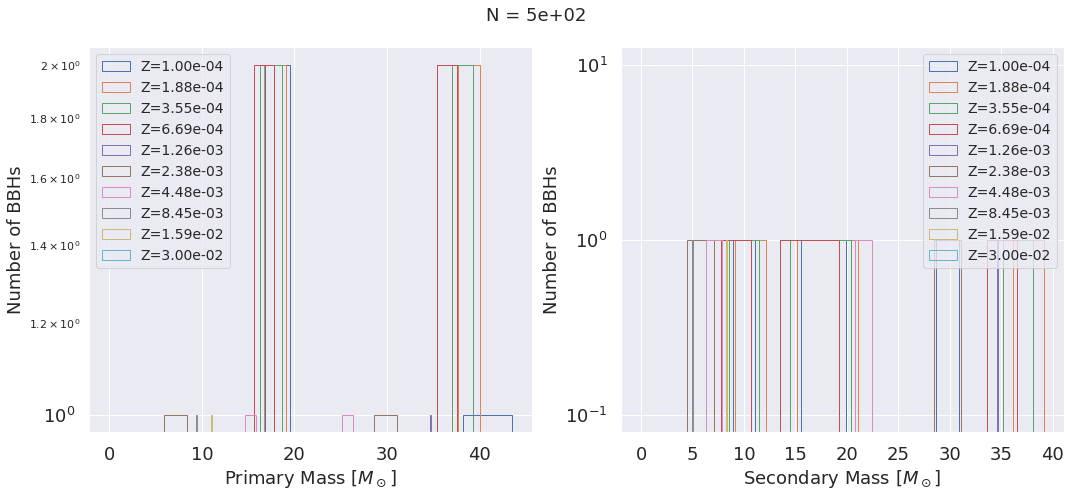

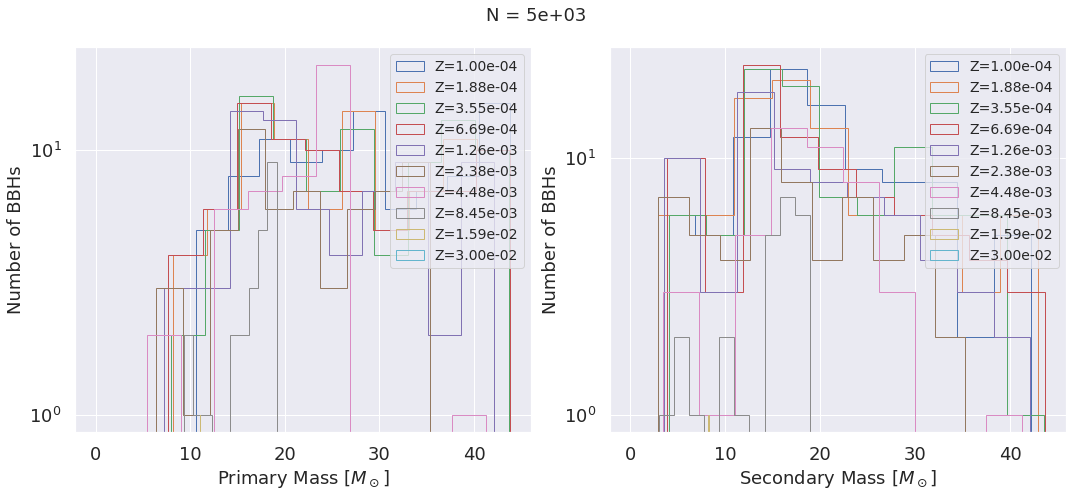

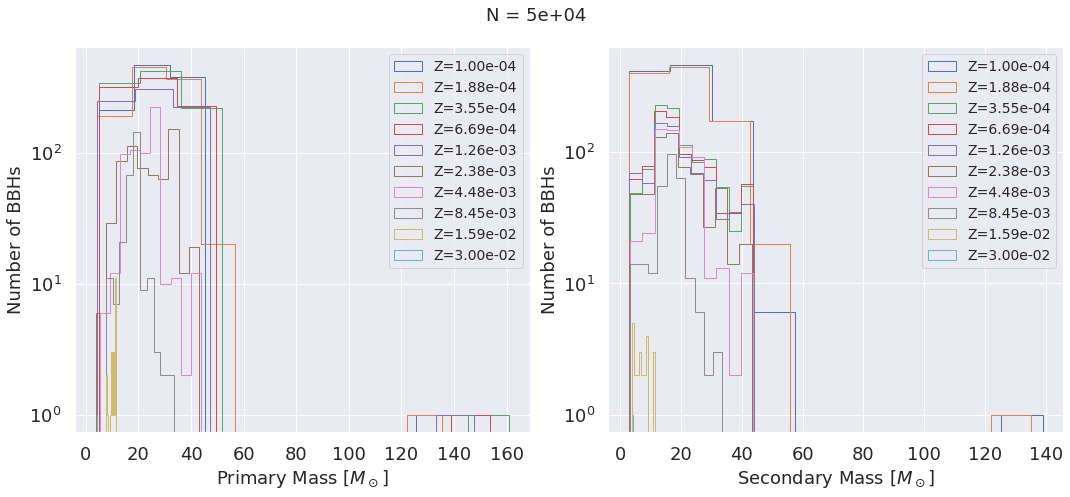

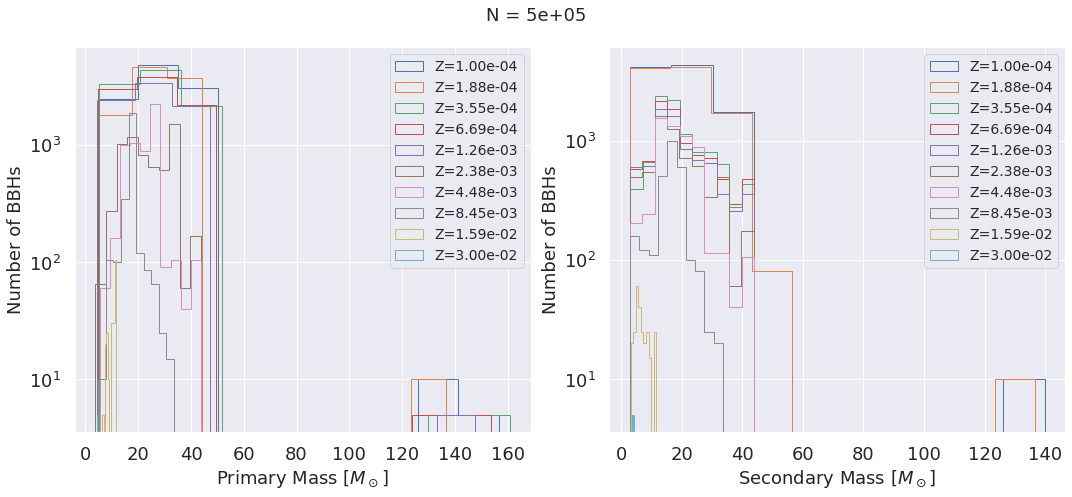

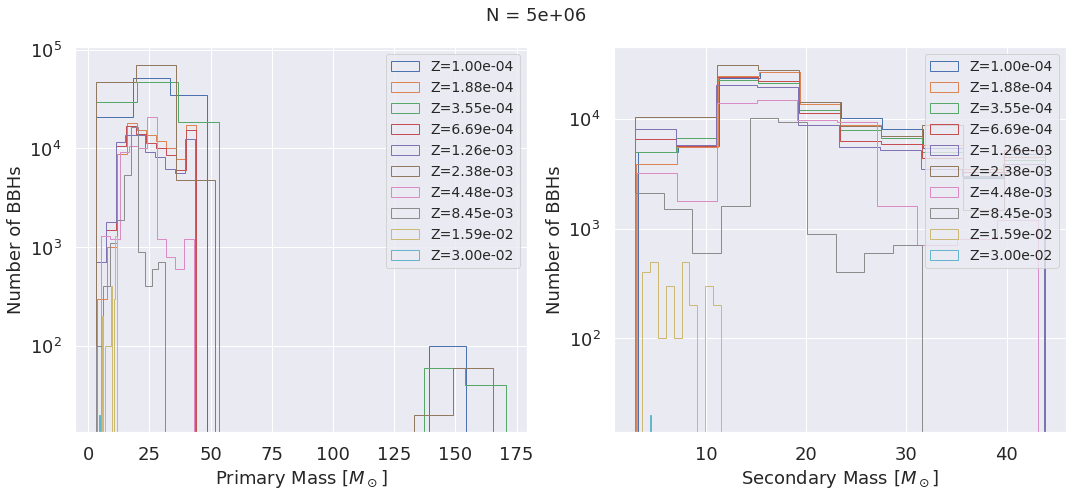

In [22]:
for n, n_system in enumerate(n_systems[:]): 
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7))
    fig.suptitle(f'N = {n_system:.0e}', fontsize=18)

    for i, met in enumerate(metallicities):
        m1 = np.asarray(M1_BBH_ALL[get_index(n, i)])
        m2 = np.asarray(M2_BBH_ALL[get_index(n, i)])

        m_max_bbh = np.maximum(m1, m2)
        m_min_bbh = np.minimum(m1, m2)
        

        
        ax1.hist(m_max_bbh, histtype='step', label=f'Z={met:.2e}') 
        ax2.hist(m_min_bbh, histtype='step', label=f'Z={met:.2e}')

    layoutAxes(ax=ax1, nameX='Primary Mass [$M_\odot$]',\
           nameY='Number of BBHs')
    layoutAxes(ax=ax2, nameX='Secondary Mass [$M_\odot$]',\
           nameY='Number of BBHs')
    ax1.legend(fontsize=14)
    ax2.legend(fontsize=14)
        
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

## Delay Time Distribution

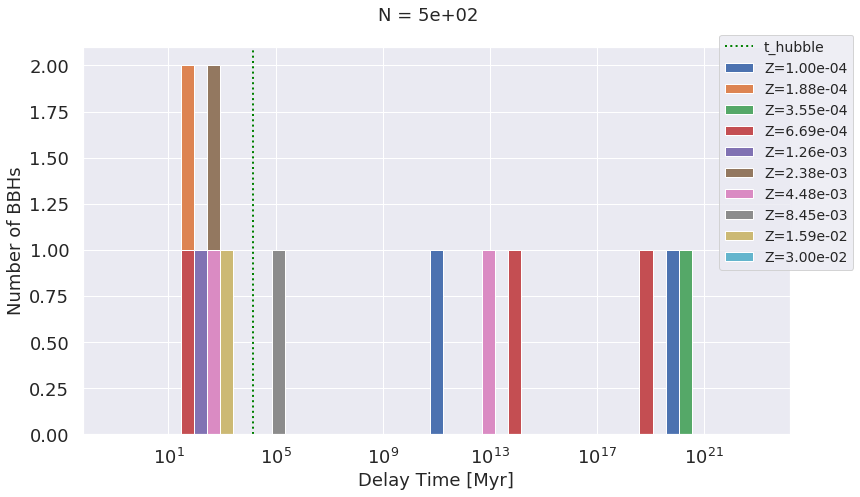

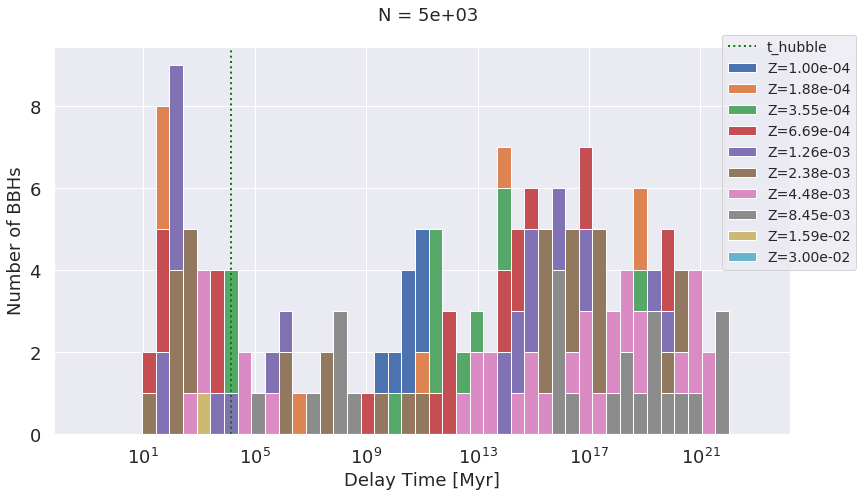

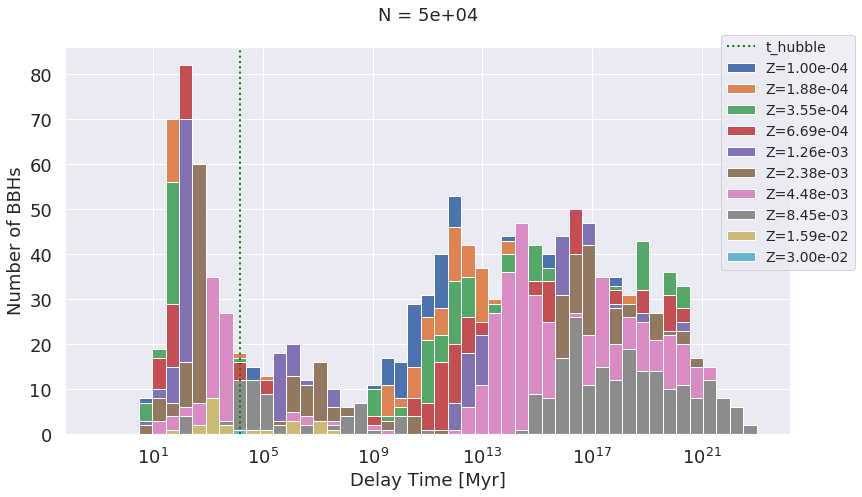

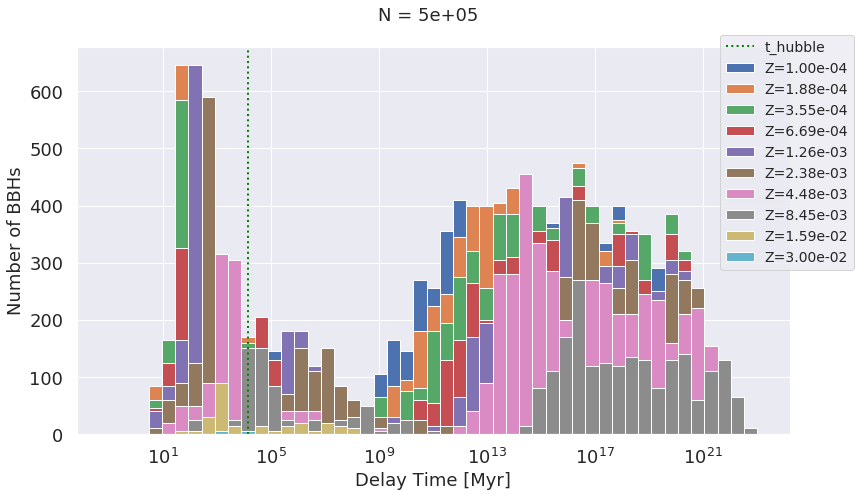

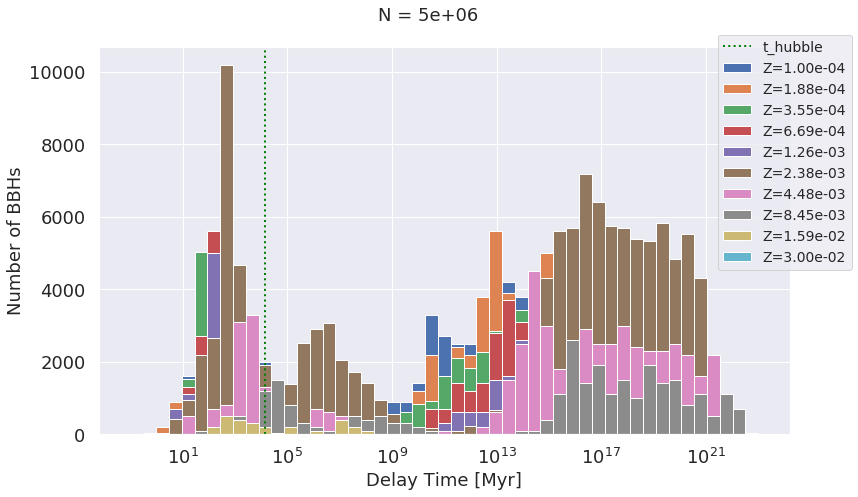

In [23]:
for n, n_system in enumerate(n_systems[:]): 
    fig, ((ax1)) = plt.subplots(1, 1, figsize=(12,7))
    fig.suptitle(f'N = {n_system:.0e}', fontsize=18)
    bins=np.logspace(np.log10(0.1),np.log10(1e23), 50)
    
    for i, met in enumerate(metallicities):
        ax1.hist(DELAY_TIMES_BBH_ALL[get_index(n,i)], bins=bins, stacked=True, label=f'Z={met:.2e}') 
    


    layoutAxes(ax=ax1, nameX='Delay Time [Myr]',\
           nameY='Number of BBHs')

    plt.axvline(x=T_HUBBLE_MYR, color='green', ls=':', lw=2, label='t_hubble')
    ax1.legend(bbox_to_anchor=(1.1, 1.05), fontsize=14)
        
#     ax1.set_yscale('log')
    ax1.set_xscale('log')
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

# 2D plots

In [24]:
from matplotlib.ticker import FormatStrFormatter

In [25]:
hubble_mergers = np.zeros([len(SFM_ALL), len(metallicities)])

for n in range(len(SFM_ALL)):
    for z in range(len(metallicities)):
        hubble_mergers[n][z] = np.sum(DELAY_TIMES_BBH_ALL[get_index(n,z)] < T_HUBBLE_MYR)
        

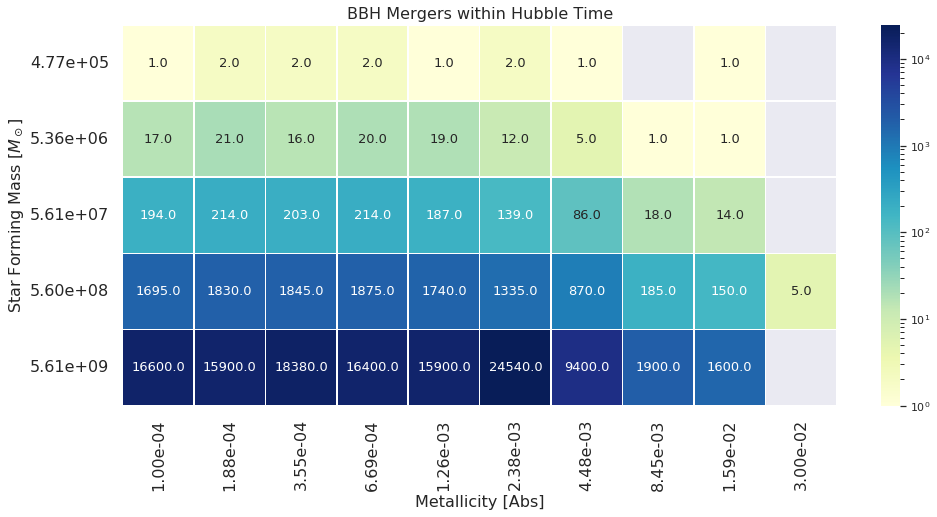

In [64]:
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 

ax = sns.heatmap(hubble_mergers, cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), \
                 xticklabels=metallicities, yticklabels=SFM_ALL, \
                annot=hubble_mergers, annot_kws={'fontsize':13}, fmt='.1f')

layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [$M_\odot$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("BBH Mergers within Hubble Time", fontsize=16)

plt.show()

In [33]:
total_bbhs = np.zeros([len(SFM_ALL), len(metallicities)])

for n in range(len(SFM_ALL)):
    for z in range(len(metallicities)):
        total_bbhs[n][z] = len(M1_BBH_ALL[get_index(n,z)])

/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/apps/intel19/python3/3.7.0/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


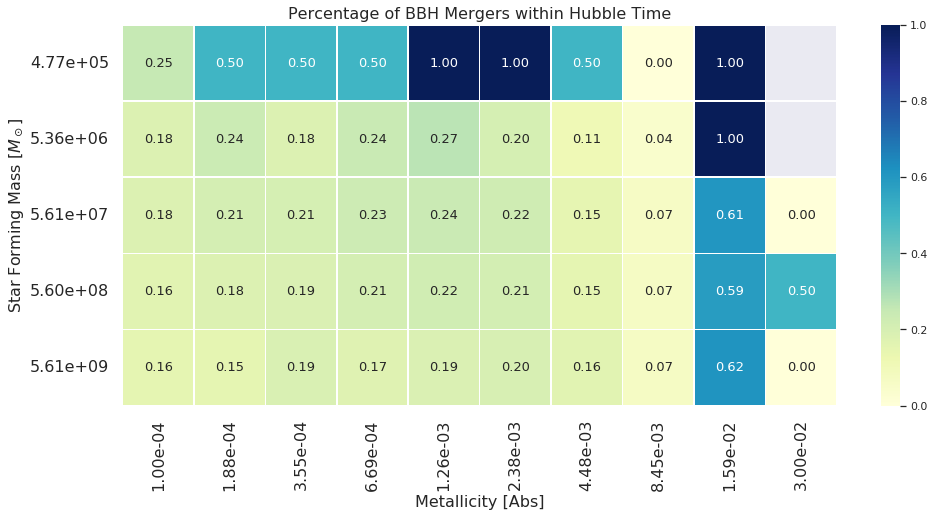

In [44]:
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 

ax = sns.heatmap(hubble_mergers/total_bbhs, cmap="YlGnBu", linewidth=0.5, \
                 xticklabels=metallicities, yticklabels=SFM_ALL, \
                 annot=hubble_mergers/total_bbhs, annot_kws={'fontsize':13}, fmt='.2f')

layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [$M_\odot$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("Percentage of BBH Mergers within Hubble Time", fontsize=16)

plt.show()

In [37]:
mergers_per_unit_sfm = np.zeros([len(SFM_ALL), len(metallicities)])

for n in range(len(SFM_ALL)):
    for z in range(len(metallicities)):
        mergers_per_unit_sfm[n][z] = np.sum(DELAY_TIMES_BBH_ALL[get_index(n,z)] < T_HUBBLE_MYR) / SFM_ALL[n]
        

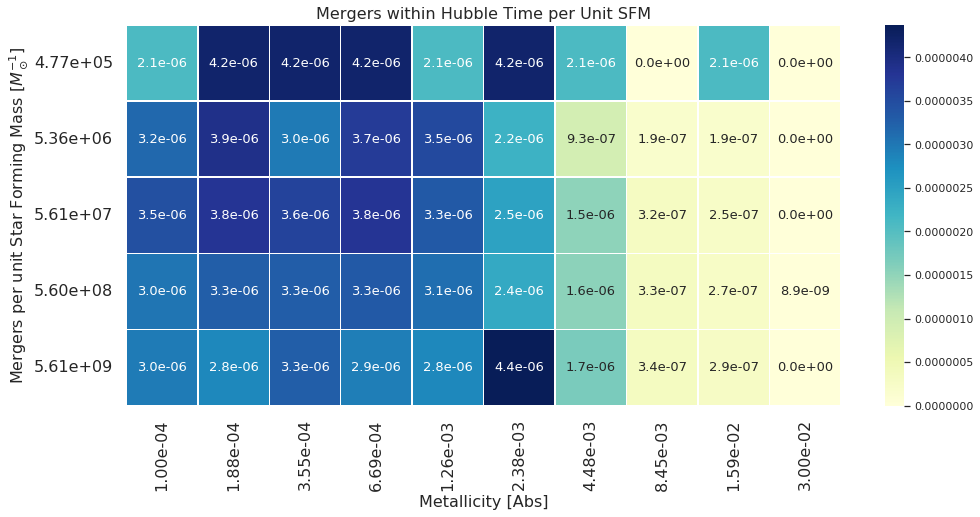

In [45]:
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 
fmt = lambda x, pos: '{:.1%}'.format(x)


ax = sns.heatmap(mergers_per_unit_sfm, cmap="YlGnBu", linewidth=0.5, \
                 xticklabels=metallicities, yticklabels=SFM_ALL,
                 annot=mergers_per_unit_sfm, annot_kws={'fontsize':13}, fmt='.1e')

layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Mergers per unit Star Forming Mass [$M_\odot^{-1}$]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)


plt.title("Mergers within Hubble Time per Unit SFM", fontsize=16)

plt.show()

In [46]:
mergers_per_unit_sfm[2]

array([3.46019228e-06, 3.81691313e-06, 3.62071666e-06, 3.81691313e-06,
       3.33533998e-06, 2.47920993e-06, 1.53389967e-06, 3.21048768e-07,
       2.49704598e-07, 0.00000000e+00])

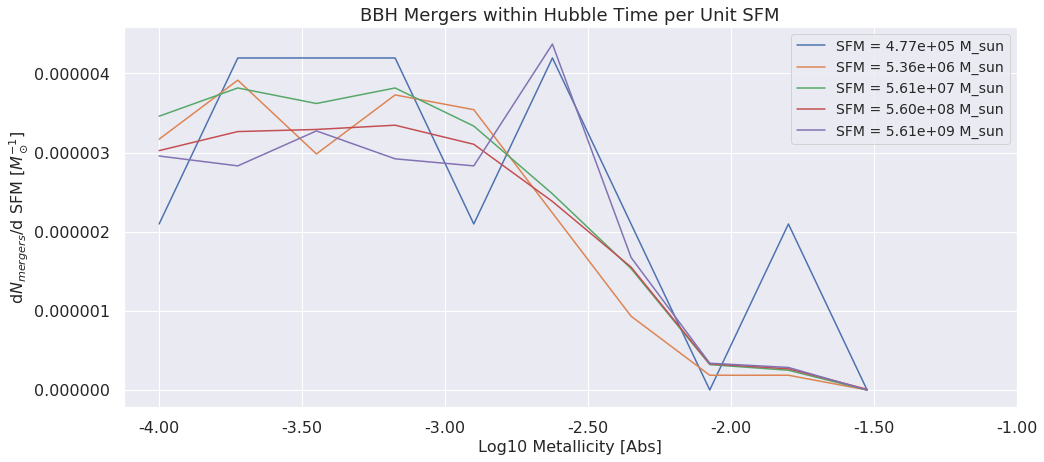

In [47]:
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 
for i, sfm in enumerate(SFM_ALL):
    ax.plot(metallicities, mergers_per_unit_sfm[i], label=f'SFM = {sfm:.2e} M_sun')

layoutAxes(ax=ax, nameX='Log10 Metallicity [Abs]',\
           nameY='d$N_{mergers}$/d SFM $[M_\odot^{-1}]$', fontsize=16)

ax.set_xscale('log')
plt.title("BBH Mergers within Hubble Time per Unit SFM", fontsize=18)

ax.set_xticks(np.log10(10**np.logspace(-4, -1, 7)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%.2f" % np.log10(x)))

plt.legend(fontsize=14)
plt.show()

# BHNS Plots for comparison

https://arxiv.org/pdf/2103.02608.pdf Figure 5 shows a peak in Mergers (within hubble time) per unit Star Forming Mass for BHNS to be at Z ~ 10^(-2.5).

In [48]:
# Isolate BHNSs
DELAY_TIMES_BHNS_ALL  = mask_type(DELAY_TIMES_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bhns')

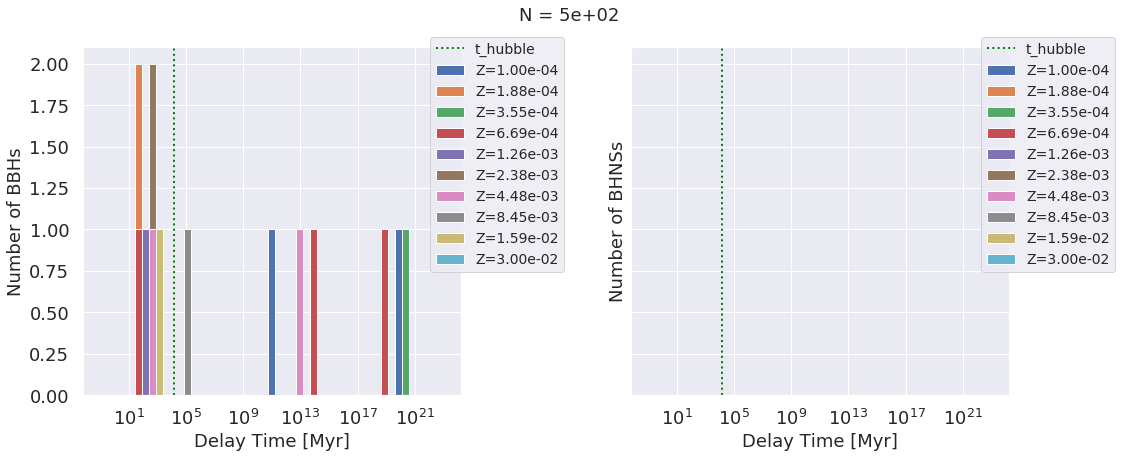

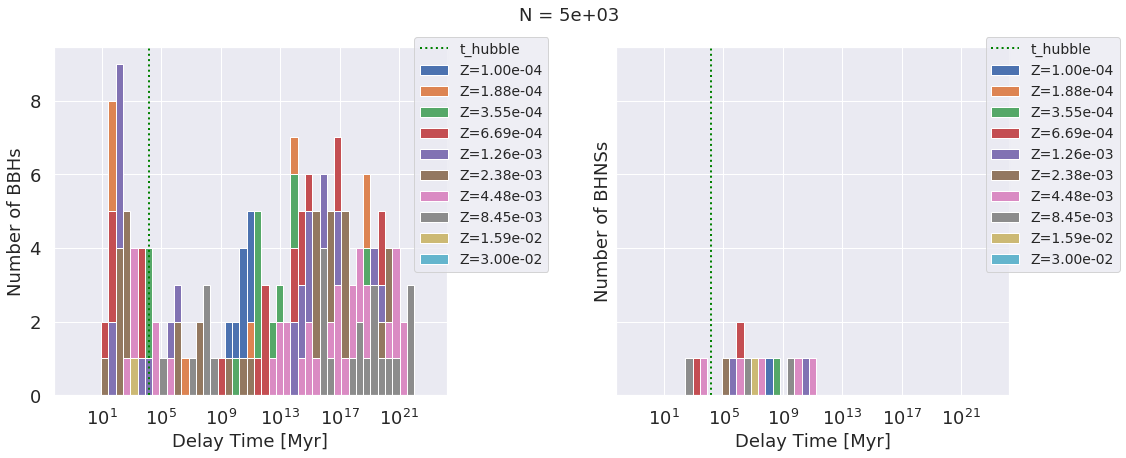

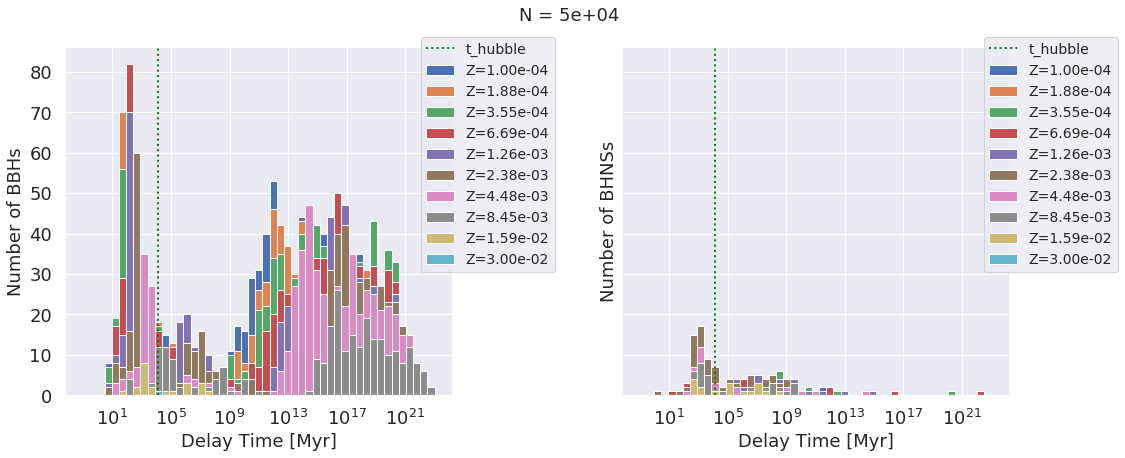

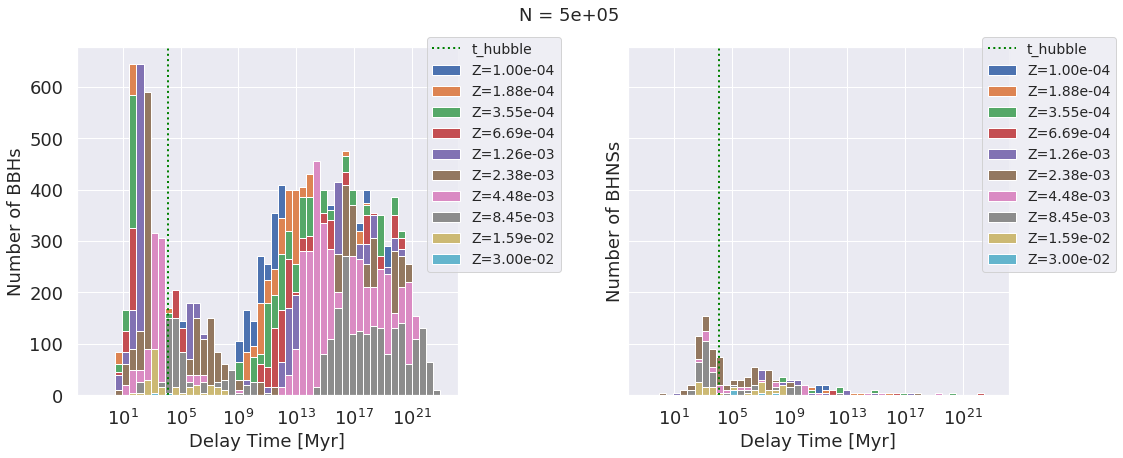

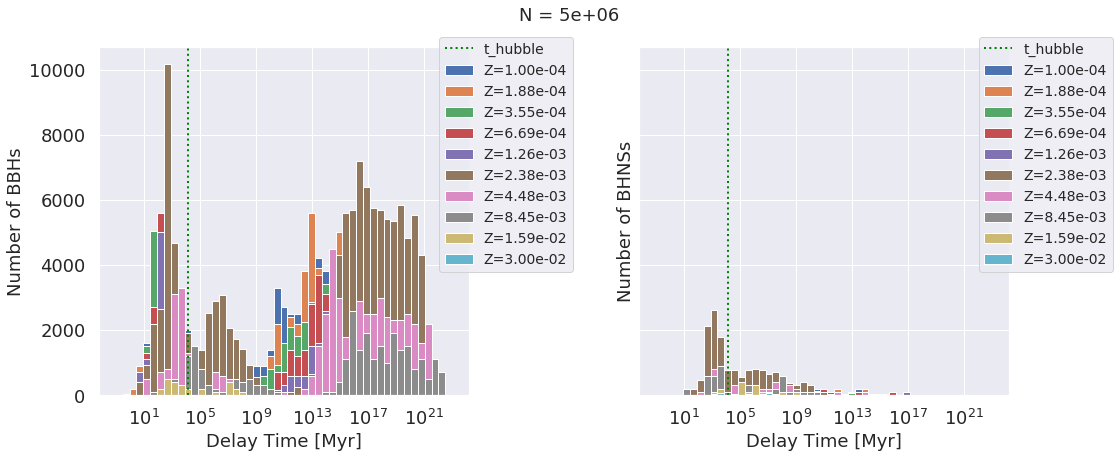

In [49]:
for n, n_system in enumerate(n_systems[:]): 
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(17,7), sharey=True)
    fig.suptitle(f'N = {n_system:.0e}', fontsize=18)
    
    bins=np.logspace(np.log10(0.1),np.log10(1e23), 50)
    
    
    for i, met in enumerate(metallicities):
        ax1.hist(DELAY_TIMES_BBH_ALL[get_index(n,i)], bins=bins, stacked=True, label=f'Z={met:.2e}') 
        ax2.hist(DELAY_TIMES_BHNS_ALL[get_index(n,i)], bins=bins, stacked=True, label=f'Z={met:.2e}') 


    layoutAxes(ax=ax1, nameX='Delay Time [Myr]',\
           nameY='Number of BBHs')
    layoutAxes(ax=ax2, nameX='Delay Time [Myr]',\
           nameY='Number of BHNSs')
    
    ax1.axvline(x=T_HUBBLE_MYR, color='green', ls=':', lw=2, label='t_hubble')
    ax2.axvline(x=T_HUBBLE_MYR, color='green', ls=':', lw=2, label='t_hubble')

        
    ax1.legend(bbox_to_anchor=(.9, 1.05), fontsize=14)
    ax2.legend(bbox_to_anchor=(1.3, 1.05), fontsize=14)


    ax1.set_xscale('log')
    ax2.set_xscale('log')

    
    fig.tight_layout(pad=5.0)
    fig.subplots_adjust(top=0.9)
    plt.show()

In [50]:
bhns_mergers_per_unit_sfm = np.zeros([len(SFM_ALL), len(metallicities)])

for n in range(len(SFM_ALL)):
    for z in range(len(metallicities)):
        bhns_mergers_per_unit_sfm[n][z] = np.sum(DELAY_TIMES_BHNS_ALL[get_index(n,z)] < T_HUBBLE_MYR) / SFM_ALL[n]

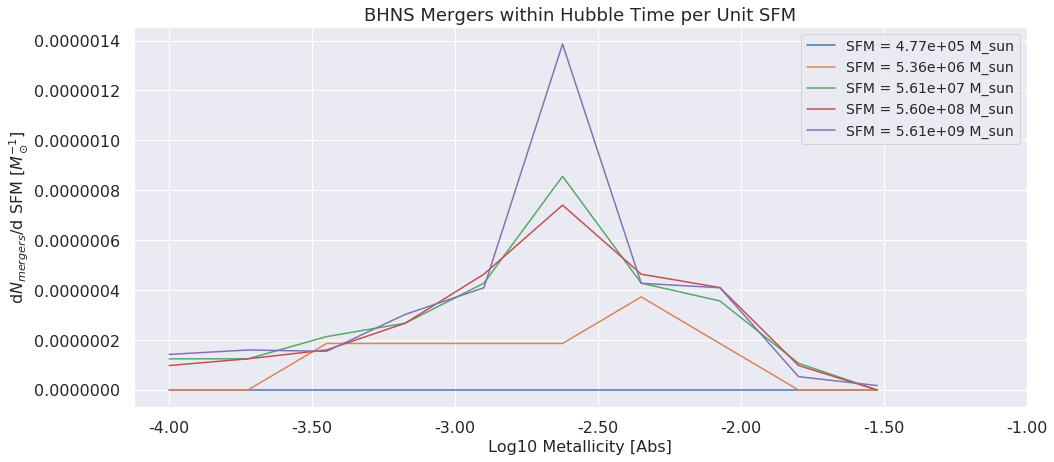

In [51]:
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 
for i, sfm in enumerate(SFM_ALL):
    ax.plot(metallicities, bhns_mergers_per_unit_sfm[i], label=f'SFM = {sfm:.2e} M_sun')

layoutAxes(ax=ax, nameX='Log10 Metallicity [Abs]',\
           nameY='d$N_{mergers}$/d SFM $[M_\odot^{-1}]$', fontsize=16)

ax.set_xscale('log')
plt.title("BHNS Mergers within Hubble Time per Unit SFM", fontsize=18)

ax.set_xticks(np.log10(10**np.logspace(-4, -1, 7)))
ax.get_xaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, pos: "%.2f" % np.log10(x)))

plt.legend(fontsize=14)
plt.show()

Good! This matches their results.

In [52]:
bhns_hubble_mergers = np.zeros([len(SFM_ALL), len(metallicities)])

for n in range(len(SFM_ALL)):
    for z in range(len(metallicities)):
        bhns_hubble_mergers[n][z] = np.sum(DELAY_TIMES_BHNS_ALL[get_index(n,z)] < T_HUBBLE_MYR)
        

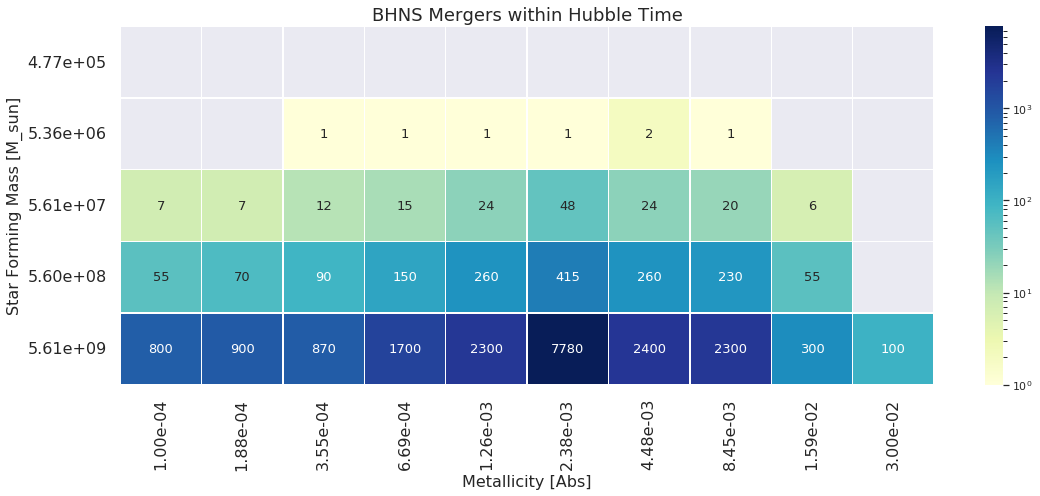

In [63]:
f, ax= plt.subplots(1, 1,  figsize=(16,7)) 

ax = sns.heatmap(bhns_hubble_mergers, cmap="YlGnBu", linewidth=0.5, norm=LogNorm(), \
                 xticklabels=metallicities, yticklabels=SFM_ALL, \
                 annot=bhns_hubble_mergers, annot_kws={'fontsize':13}, fmt='.0f')

layoutAxes(ax=ax, nameX='Metallicity [Abs]',\
           nameY='Star Forming Mass [M_sun]', fontsize=16)

fmt = '{:0.2e}'
xticklabels = []
for item in ax.get_xticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    xticklabels += [item]
yticklabels = []
for item in ax.get_yticklabels():
    item.set_text(fmt.format(float(item.get_text())))
    yticklabels += [item]

ax.set_xticklabels(xticklabels)
ax.set_yticklabels(yticklabels)

plt.title("BHNS Mergers within Hubble Time", fontsize=18)
plt.tight_layout()
plt.show()

# BNS Plots

In [39]:
DELAY_TIMES_BNS_ALL  = mask_type(DELAY_TIMES_ALL, TYPE1_CO_ALL, TYPE2_CO_ALL, dco_type='bns')

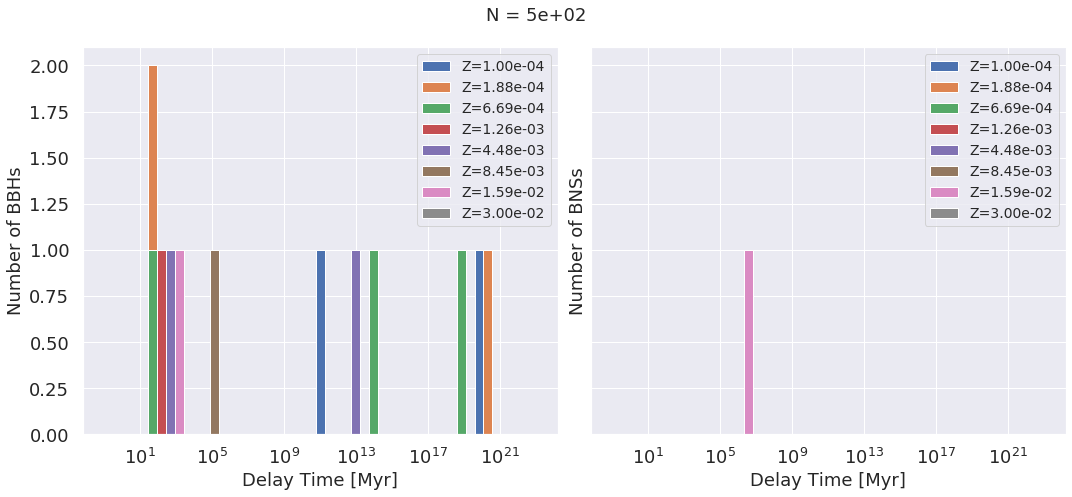

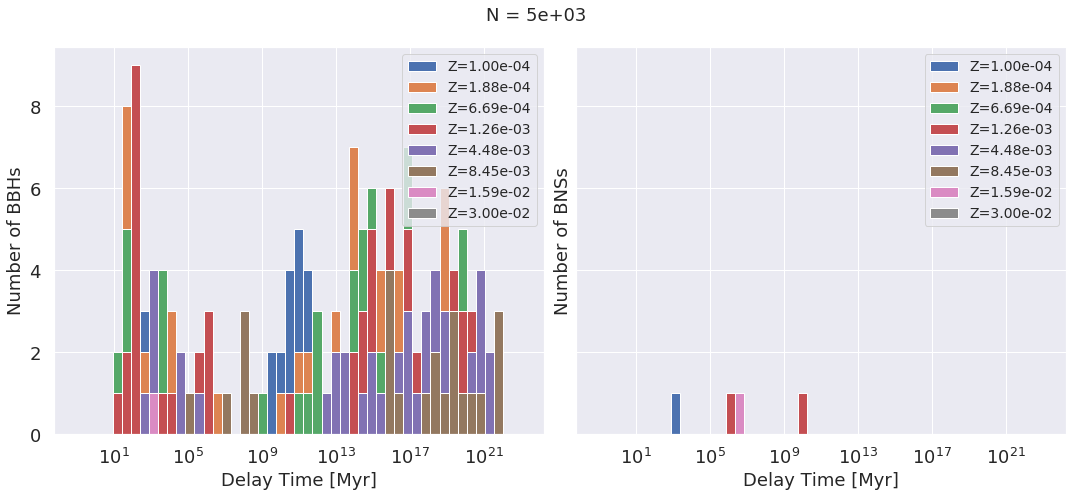

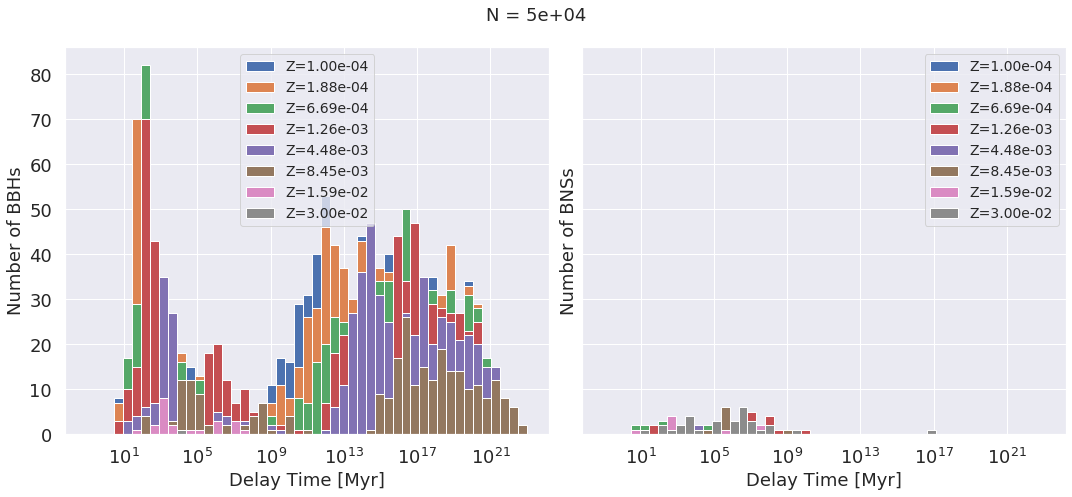

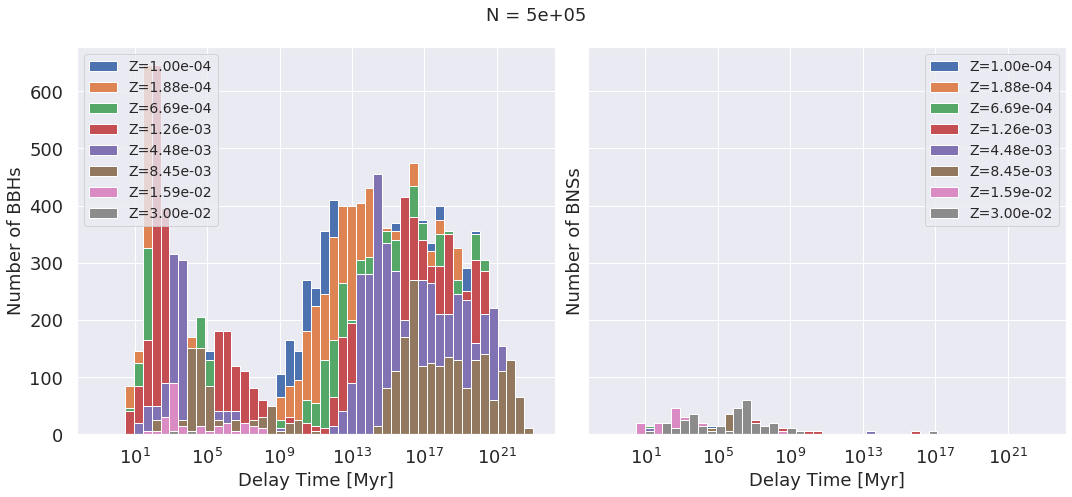

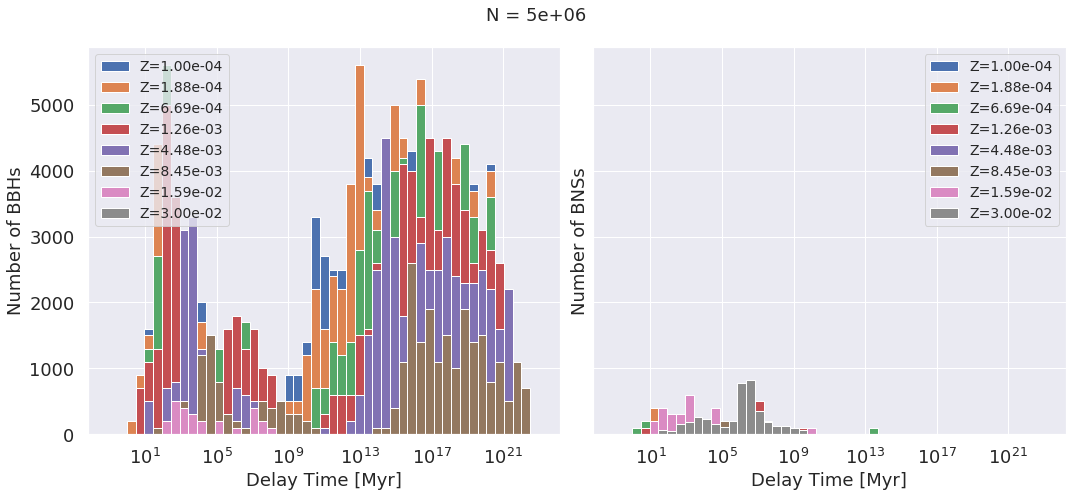

In [40]:
for n, n_system in enumerate(n_systems[:]): 
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(15,7), sharey=True)
    fig.suptitle(f'N = {n_system:.0e}', fontsize=18)
    
    bins=np.logspace(np.log10(0.1),np.log10(1e23), 50)
    
    for i, met in enumerate(metallicities):
        ax1.hist(DELAY_TIMES_BBH_ALL[get_index(n,i)], bins=bins, stacked=True, label=f'Z={met:.2e}') 
        ax2.hist(DELAY_TIMES_BNS_ALL[get_index(n,i)], bins=bins, stacked=True, label=f'Z={met:.2e}') 


    layoutAxes(ax=ax1, nameX='Delay Time [Myr]',\
           nameY='Number of BBHs')
    layoutAxes(ax=ax2, nameX='Delay Time [Myr]',\
           nameY='Number of BNSs')
    ax1.legend(fontsize=14)
    ax2.legend(fontsize=14)


    ax1.set_xscale('log')
    ax2.set_xscale('log')

    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

# General Features

In [ ]:
for n, n_system in enumerate(n_systems[4:]): 
    fig, ((ax1)) = plt.subplots(1, 1, figsize=(10,7))
    fig.suptitle(f'N = {n_system:.0e}', fontsize=18)

#     for i, met in enumerate(metallicities[:]):
#         ax1.hist(SMA_BBH_ALL[n*len(metallicities) + i], bins=50, histtype='step', label=f'Z={met:.2e}') 
    i = 4
    ax1.hist(SMA_BBH_ALL[i], bins=100, histtype='step', label=f'Z={metallicities[i]:.2e}') 
    
    x = np.linspace(0, 2000, 1000)
    norm = 2e5
    ax1.plot(x, norm/x, label='1/a')

    layoutAxes(ax=ax1, nameX='Sem-Maj Axis [AU]',\
           nameY='Number of BBHs')

    ax1.legend(fontsize=14)
        
    ax1.set_yscale('log')
#     ax1.set_xscale('log')
    plt.xlim(0, 2000)
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
for n, n_system in enumerate(n_systems[4:]): 
    fig, ((ax1)) = plt.subplots(1, 1, figsize=(10,7))
    fig.suptitle(f'N = {n_system:.0e}', fontsize=18)

    i = 4
    ax1.hist(ECC_BBH_ALL[i], bins=100, histtype='step', label=f'Z={metallicities[i]:.2e}') 
    
    x = np.linspace(0, 1, 1000)
    norm = 10
    ax1.plot(x, norm/x, label='1/e')

    layoutAxes(ax=ax1, nameX='Eccentricity at DCO Formation',\
           nameY='Number of BBHs')

    ax1.legend(fontsize=14)
        
#     ax1.set_yscale('log')
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

# Mass Ratio Plots

In [43]:
import scipy.stats as stats

In [47]:
len(M1_BBH_ALL)

40

In [51]:
index = 35
m1 = np.asarray(M1_BBH_ALL[index])
m2 = np.asarray(M2_BBH_ALL[index])

m_max_bbh = np.maximum(m1, m2)
m_min_bbh = np.minimum(m1, m2)
q_bbh = m_min_bbh/m_max_bbh
print(q_bbh)
print(all(x <= 1 for x in q_bbh))


m1_zams = np.asarray(M1_ZAMS_ALL[index])
m2_zams = np.asarray(M2_ZAMS_ALL[index])

m_max_zams = np.maximum(m1_zams, m2_zams)
m_min_zams = np.minimum(m1_zams, m2_zams)
q_zams = m_min_zams/m_max_zams
print(q_zams)
print(all(x <= 1 for x in q_zams))

[1.         0.82326797 0.89128779 ... 0.31989122 0.94398042 0.90017185]
True
[0.49700007 0.48150957 0.46998212 ... 0.17653377 0.25367367 0.97643502]
True


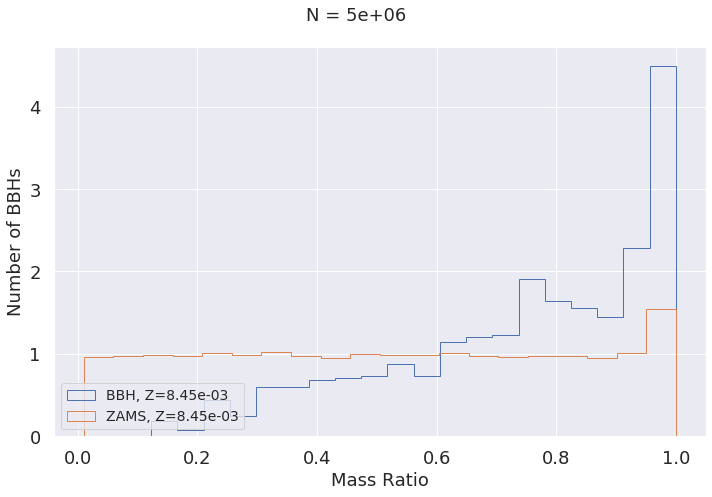

In [54]:
for n, n_system in enumerate(n_systems[4:]): 
    fig, ((ax1)) = plt.subplots(1, 1, figsize=(10,7))
    fig.suptitle(f'N = {n_system:.0e}', fontsize=18)
    
    i=5
    ax1.hist(q_bbh, bins=20, histtype='step', density=True, label=f'BBH, Z={metallicities[i]:.2e}')
    ax1.hist(q_zams, bins=20, histtype='step', density=True, label=f'ZAMS, Z={metallicities[i]:.2e}')

    x = np.linspace(0, 1, 1000)
    y = 100*x
#     ax1.plot(x, y, label='linear')

    layoutAxes(ax=ax1, nameX='Mass Ratio',\
           nameY='Number of BBHs')

    ax1.legend(fontsize=14, loc='lower left')
        
#     ax1.set_yscale('log')
    
    fig.tight_layout()
    fig.subplots_adjust(top=0.9)
    plt.show()

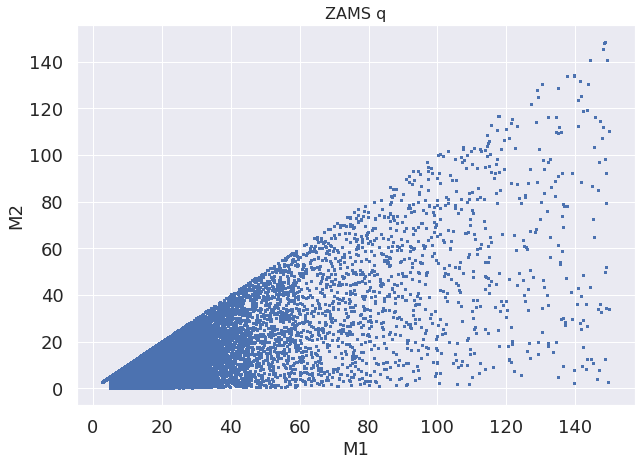

In [55]:
fig, ((ax1)) = plt.subplots(1, 1, figsize=(10,7))

plt.scatter(m_max_zams, m_min_zams, s=2)
layoutAxes(ax=ax1, nameX='M1',\
           nameY='M2')
plt.title("ZAMS q", fontsize=16)
plt.show()

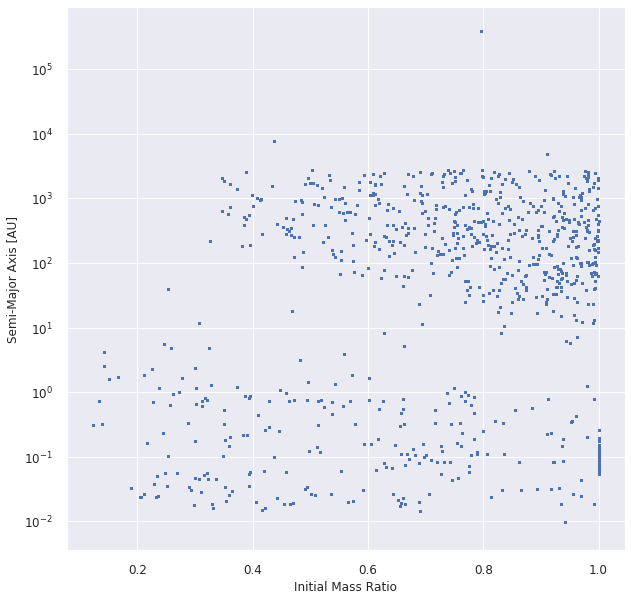

In [57]:
sma_bbh = np.asarray(SMA_BBH_ALL[index])
fig, ((ax1)) = plt.subplots(1, 1, figsize=(10,10))

ax1.scatter(q_bbh, sma_bbh, s=2)

layoutAxes(ax=ax1, nameX='Initial Mass Ratio',\
           nameY='Semi-Major Axis [AU]', fontsize=12)

ax1.set_yscale('log')

plt.show()

# old code

In [11]:
# DCOs = double compact objects
DCOs = Data['BSE_Double_Compact_Objects']
print(list(DCOs.keys()))

['Coalescence_Time', 'Eccentricity@DCO', 'Mass(1)', 'Mass(2)', 'Merges_Hubble_Time', 'Recycled_NS(1)', 'Recycled_NS(2)', 'SEED', 'SemiMajorAxis@DCO', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Time']


In [22]:
(Data['BSE_Double_Compact_Objects']["Coalescence_Time"][...].squeeze() - 13e3 <= 0) - Data['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][...].squeeze()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [15]:
Data['BSE_Double_Compact_Objects']["Merges_Hubble_Time"][...].squeeze()

array([0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0,

In [22]:
m1 = DCOs['Mass(1)'][()]
m2 = DCOs['Mass(2)'][()]

st1 = DCOs['Stellar_Type(1)'][()]
st2 = DCOs['Stellar_Type(2)'][()]

SEED_DCO = DCOs['SEED'][()]

merger_t =  DCOs['Coalescence_Time'][()]
print(DCOs['Coalescence_Time'].attrs['units'])

b'Myr'


In [16]:
InitStars = Data['BSE_System_Parameters']
print(list(InitStars.keys()))

['CE_Alpha', 'Eccentricity@ZAMS', 'Equilibrated_At_Birth', 'Error', 'LBV_Factor', 'Mass@ZAMS(1)', 'Mass@ZAMS(2)', 'Merger', 'Merger_At_Birth', 'Metallicity@ZAMS(1)', 'Metallicity@ZAMS(2)', 'Omega@ZAMS(1)', 'Omega@ZAMS(2)', 'SEED', 'SN_Kick_Magnitude_Random_Number(1)', 'SN_Kick_Magnitude_Random_Number(2)', 'SN_Kick_Mean_Anomaly(1)', 'SN_Kick_Mean_Anomaly(2)', 'SN_Kick_Phi(1)', 'SN_Kick_Phi(2)', 'SN_Kick_Theta(1)', 'SN_Kick_Theta(2)', 'SemiMajorAxis@ZAMS', 'Sigma_Kick_CCSN_BH', 'Sigma_Kick_CCSN_NS', 'Sigma_Kick_ECSN', 'Sigma_Kick_USSN', 'Stellar_Type(1)', 'Stellar_Type(2)', 'Stellar_Type@ZAMS(1)', 'Stellar_Type@ZAMS(2)', 'Unbound', 'WR_Factor']


In [20]:
z1 = InitStars['Metallicity@ZAMS(1)'][()]
z2 = InitStars['Metallicity@ZAMS(2)'][()]
SEED_ZAMS = InitStars['SEED'][()]

In [21]:
print(z2)

[0.000142 0.000142 0.000142 ... 0.000142 0.000142 0.000142]
